In [1]:
from pathlib import Path
import numpy as np

def _load_mat_v5(path):
    from scipy.io import loadmat
    # simplify_cells=True converts MATLAB structs/cell arrays into plain dicts/lists
    return loadmat(path, simplify_cells=True)

def _load_mat_v73(path):
    """
    Try mat73 first (best for structs). If unavailable, fall back to h5py
    to at least load numeric arrays.
    """
    try:
        import mat73  # pip install mat73
        return mat73.loadmat(path)
    except Exception:
        import h5py
        out = {}
        with h5py.File(path, "r") as f:
            for key in ["vib_x", "vib_y", "vib_z", "t", "XYZ", "index"]:
                if key in f:
                    out[key] = f[key][()]
        return out

def load_scan_mat(path, as_xarray=True):
    """
    Returns a dict with numpy arrays and, if as_xarray=True, an xarray.Dataset too.
    """
    path = Path(path).as_posix()

    # Detect v7.3 (HDF5) vs older MAT
    import h5py
    data = _load_mat_v73(path) if h5py.is_hdf5(path) else _load_mat_v5(path)

    # Extract main arrays
    vib_x = np.asarray(data["vib_x"])  # shape (n_pos, n_time)
    vib_y = np.asarray(data["vib_y"])
    vib_z = np.asarray(data["vib_z"])
    t     = np.asarray(data["t"]).ravel()         # (n_time,)
    XYZ   = np.asarray(data["XYZ"])               # (n_pos, 3)
    index = np.asarray(data.get("index", np.arange(vib_x.shape[0])+1)).ravel()  # MATLAB is 1-based

    # Optional structs (if you need them later)
    usd_x = data.get("usd_x", None)
    usd_y = data.get("usd_y", None)
    usd_z = data.get("usd_z", None)

    out = dict(
        vib_x=vib_x, vib_y=vib_y, vib_z=vib_z,
        t=t, XYZ=XYZ, index=index,
        usd_x=usd_x, usd_y=usd_y, usd_z=usd_z
    )

    if not as_xarray:
        return out

    # Build a convenient xarray Dataset
    try:
        import xarray as xr
        n_pos, n_time = vib_x.shape
        ds = xr.Dataset(
            coords={
                "pos":  ("pos", np.arange(n_pos, dtype=int)),
                "time": ("time", t),
                "x":    ("pos", XYZ[:, 0]),
                "y":    ("pos", XYZ[:, 1]),
                "z":    ("pos", XYZ[:, 2]),
                "index":("pos", index),
            },
            data_vars={
                "vib_x": (("pos", "time"), vib_x),
                "vib_y": (("pos", "time"), vib_y),
                "vib_z": (("pos", "time"), vib_z),
            },
            attrs={"source_file": Path(path).name},
        )
        out["dataset"] = ds
    except ImportError:
        pass

    return out

In [2]:
scan = load_scan_mat("../../grid_scan_dx_dy_1_5mm_fc_25kHz_fs_625kHz_100avg_1250nt_200V_scatter.mat")     # returns dict; scan["dataset"] if xarray is installed
ds = scan.get("dataset")

# Example: first position trace of vib_x
if ds is not None:
    import matplotlib.pyplot as plt
    plt.plot(ds["time"].values, ds["vib_x"].isel(pos=0).values)
    plt.xlabel("time (t)"); plt.ylabel("vib_x amplitude"); plt.show()

In [ ]:
file = np



In [3]:
scan.keys()

dict_keys(['vib_x', 'vib_y', 'vib_z', 't', 'XYZ', 'index', 'usd_x', 'usd_y', 'usd_z'])

In [4]:
vib_z = scan["vib_z"]
vib_y = scan["vib_y"]
vib_x = scan["vib_x"]
usd_x = scan["usd_x"]
t = scan["t"]
XYZ = scan["XYZ"]


In [5]:
print(vib_z.shape,t.shape,XYZ.shape)
print("time step duration:", t[1]-t[0])

(11229, 938) (938,) (11229, 3)
time step duration: 1.6e-06


In [6]:
print(XYZ)

[[0.37475625 0.63181436 0.12950923]
 [0.3750034  0.63333213 0.12960717]
 [0.37525192 0.63491243 0.12957202]
 ...
 [0.08059038 0.73169279 0.13407423]
 [0.08055817 0.73338461 0.13393307]
 [0.07326281 0.75608897 0.07720331]]


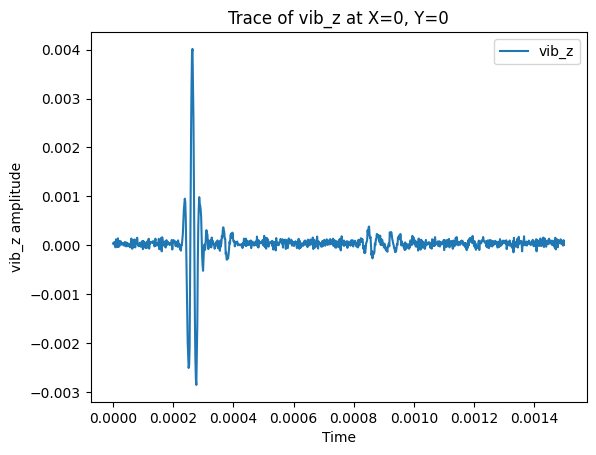

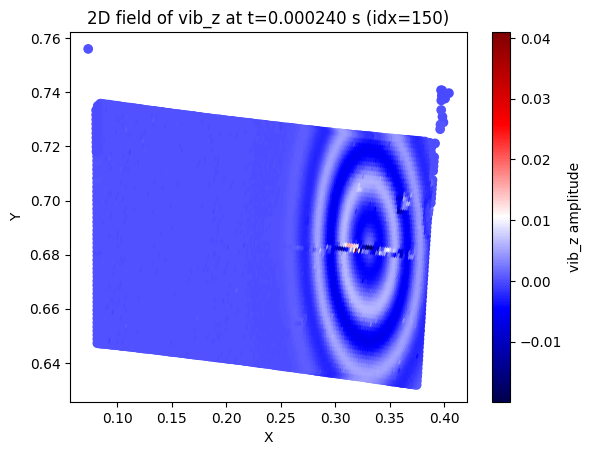

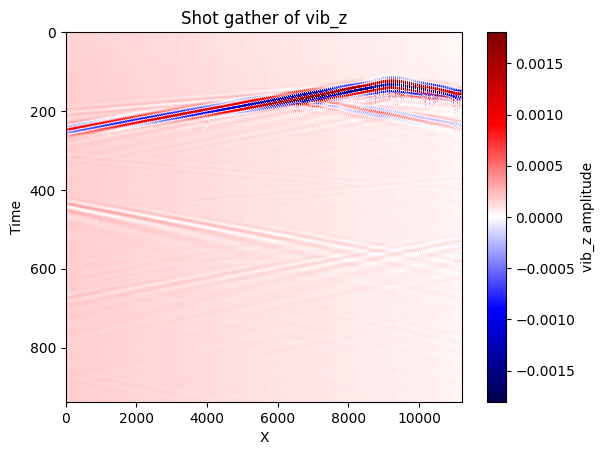

In [7]:
# for a few time in the vib_z plot the evoluation of the 2D field with the XYZ. each point in a single time step of the vib_z as a cordinate in XYZ

# Example: Plotting the first trace of vib_z
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t, vib_z[0, :], label="vib_z")
plt.xlabel("Time")
plt.ylabel("vib_z amplitude")
plt.title("Trace of vib_z at X=0, Y=0")
plt.legend()
plt.show()

# Plot the 2D field for several selected time steps to visualize the evolution. Each scanning point is 1.5mm apart in a grid.

idx = 150
plt.figure()
sc = plt.scatter(XYZ[:, 0], XYZ[:, 1], c=vib_z[:, idx], cmap="seismic")
plt.colorbar(sc, label="vib_z amplitude")
plt.title(f"2D field of vib_z at t={t[idx]:.6f} s (idx={idx})")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()



# make a shotgather type of plot whre the y axis is time and the x axis is space
factor = 30  # to convert mm to m for better visualization
plt.figure()
plt.imshow(np.fliplr(vib_z[:, :].T), aspect="auto", cmap="seismic",vmin=-np.max(np.abs(vib_z))/factor, vmax=np.max(np.abs(vib_z))/factor)
plt.colorbar(label="vib_z amplitude")
plt.title("Shot gather of vib_z")
plt.xlabel("X")
plt.ylabel("Time")
plt.show()


In [8]:

def _slice_time(field, t, tlim):
    """Return field[:, tmask] and t[tmask] for the requested time window."""
    t = np.asarray(t).ravel()

    # Make time increasing for masking convenience
    if t[0] > t[-1]:
        t = t[::-1]
        field = field[:, ::-1]

    if tlim is None:
        return field, t

    t0, t1 = tlim
    if t0 > t1:      # accept either order
        t0, t1 = t1, t0

    mask = (t >= t0) & (t <= t1)
    if not mask.any():
        raise ValueError(f"No samples inside time window {t0}–{t1} s.")
    return field[:, mask], t[mask]

def plot_shotgather_axis(field, t, XYZ, *,
                         axis="x", unit="m", space_scale=1.0,
                         clip_div=30, tlim=None, reverse=False):
    """
    field: (n_data, n_time)
    t:     (n_time,)
    XYZ:   (n_data, 3)
    axis:  'x' | 'y' | 'z' to order traces
    space_scale: multiply XYZ by this (e.g., 1e-3 to convert mm->m)
    tlim:  (t0, t1) in seconds — optional time window to plot
    """
    field_sel, t_sel = _slice_time(field, t, tlim)

    ax_id = {"x":0, "y":1, "z":2}[axis]
    s = np.asarray(XYZ)[:, ax_id] * space_scale
    idx = np.argsort(s)
    if reverse:
        idx = idx[::-1]

    A = np.max(np.abs(field_sel))
    vmax = A / clip_div

    plt.figure(figsize=(8, 4))
    plt.imshow(field_sel[idx, :].T,
               extent=[s[idx].min(), s[idx].max(), t_sel.max(), t_sel.min()],
               origin="upper", aspect="auto", cmap="seismic",
               vmin=-vmax, vmax=vmax)
    plt.colorbar(label="Amplitude")
    axlabel = {"x":"X", "y":"Y", "z":"Z"}[axis]
    plt.xlabel(f"Distance along {axlabel} ({unit})")
    plt.ylabel("Time (s)")
    ttl = f"Shot gather (sorted by {axlabel}"
    ttl += f", {t_sel[0]:.3f}–{t_sel[-1]:.3f} s)" if tlim else ")"
    plt.title(ttl)
    plt.tight_layout()
    plt.show()

def plot_shotgather_auto(field, t, XYZ, *,
                         unit="m", space_scale=1.0,
                         clip_div=30, tlim=None, reverse=False):
    """
    Orders traces along the dominant line (PCA) through XYZ; useful if the
    receiver line isn’t exactly axis-aligned. Supports a time window via tlim.
    """
    field_sel, t_sel = _slice_time(field, t, tlim)

    X0 = np.asarray(XYZ) * space_scale
    X0 = X0 - X0.mean(0)
    _, _, vh = np.linalg.svd(X0, full_matrices=False)
    d = vh[0]                   # principal direction
    s = X0 @ d                  # 1D coordinate along the line
    idx = np.argsort(s)
    if reverse:
        idx = idx[::-1]

    A = np.max(np.abs(field_sel))
    vmax = A / clip_div

    plt.figure(figsize=(8, 4))
    plt.imshow(field_sel[idx, :].T,
               extent=[s[idx].min(), s[idx].max(), t_sel.max(), t_sel.min()],
               origin="upper", aspect="auto", cmap="seismic",
               vmin=-vmax, vmax=vmax)
    plt.colorbar(label="Amplitude")
    plt.xlabel(f"Distance along line ({unit})")
    plt.ylabel("Time (s)")
    ttl = "Shot gather (auto-ordered"
    ttl += f", {t_sel[0]:.3f}–{t_sel[-1]:.3f} s)" if tlim else ")"
    plt.title(ttl)
    plt.tight_layout()
    plt.show()

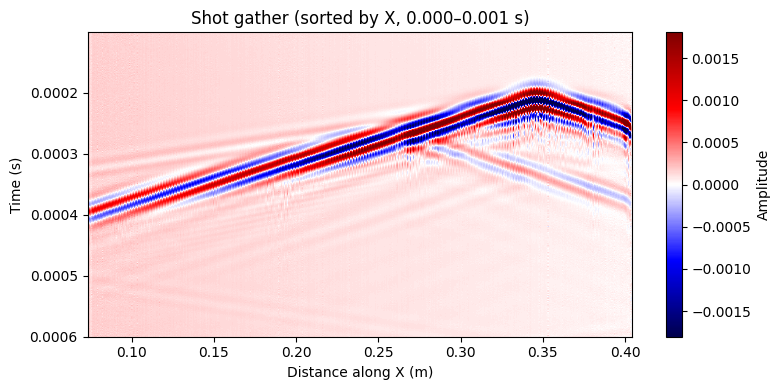

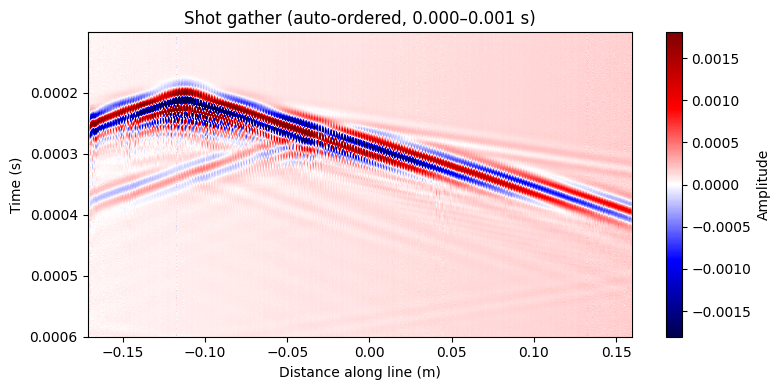

In [9]:
# If XYZ is in mm and you want meters:
space_scale = 1

# Plot 0.02–0.08 s along X:
plot_shotgather_axis(vib_z, t, XYZ, axis="x", unit="m",
                     space_scale=space_scale, tlim=(1e-4, 6e-4))

# Auto-ordered gather for 0.01–0.06 s:
plot_shotgather_auto(vib_z, t, XYZ, unit="m",
                     space_scale=space_scale, tlim=(1e-4, 6e-4))

In [14]:
print(vib_z.shape)

(11229, 938)


MovieWriter imagemagick unavailable; using Pillow instead.


IndexError: index 938 is out of bounds for axis 1 with size 938

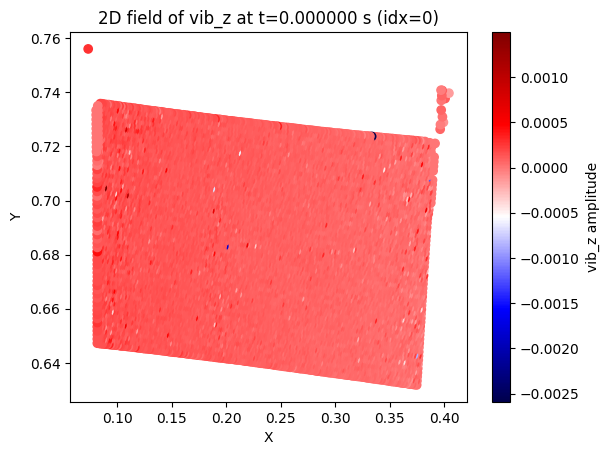

In [ ]:
# make a gif of the 2D wavefield of vib_z, saving only every 50 frames
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
sc = ax.scatter(XYZ[:, 0], XYZ[:, 1], c=vib_z[:, 0], cmap="seismic", animated=True)
plt.colorbar(sc, label="vib_z amplitude")
plt.title(f"2D field of vib_z at t={t[0]:.6f} s (idx={0})")
plt.xlabel("X")
plt.ylabel("Y")

def update(frame):
    sc.set_array(vib_z[:, frame])
    ax.set_title(f"2D field of vib_z at t={t[frame]:.6f} s (idx={frame})")
    return sc,

frames = np.arange(0, vib_z.shape[1], 50)
ani = animation.FuncAnimation(fig, update, frames=frames, interval=100)
ani.save('vib_z_every50.gif', writer='imagemagick')